# Proyecto Final Task Paralela Test A/B

## Introducción 

He recibido una tarea analítica de una tienda en línea internacional. Mis predecesores no consiguieron completarla: lanzaron una prueba A/B y luego abandonaron (para iniciar una granja de sandías en Brasil). Solo dejaron las especificaciones técnicas y los resultados de las pruebas.

Mi tarea es: 

Comprobar si la prueba se ha realizado correctamente y analizar los resultados.

## Descripción tecnica

Descripción técnica:
    
Nombre de la prueba: recommender_system_test
    
Grupos: А (control), B (nuevo embudo de pago)
    
Fecha de lanzamiento: 2020-12-07
    
Fecha en la que dejaron de aceptar nuevos usuarios: 2020-12-21
    
Fecha de finalización: 2021-01-01
    
Audiencia: 15% de los nuevos usuarios de la región de la UE
    
Propósito de la prueba: probar cambios relacionados con la introducción de un sistema de recomendaciones mejorado
    
Resultado esperado: dentro de los 14 días posteriores a la inscripción, los usuarios mostrarán una mejor conversión en vistas de la página del producto (el evento product_page), instancias de agregar artículos al carrito de compras (product_cart) y compras (purchase). 
En cada etapa del embudo product_page → product_cart → purchase, habrá al menos un 10% de aumento.

Número previsto de participantes de la prueba: 6 000

## Descripción de los datos

Estructura ab_project__marketing_events_us.csv:

name — el nombre del evento de marketing

regions — regiones donde se llevará a cabo la campaña publicitaria

start_dt — fecha de inicio de la campaña

finish_dt — fecha de finalización de la campaña

Estructura final_ab_new_users_upd_us.csv:

user_id

first_date — fecha de inscripción

region

device — dispositivo utilizado para la inscripción

Estructura final_ab_events_upd_us.csv:

user_id

event_dt — fecha y hora del evento

event_name — nombre del tipo de evento

details — datos adicionales sobre el evento (por ejemplo, el pedido total en USD para los eventos purchase)

Estructura final_ab_participants_upd_us.csv:

user_id

ab_test — nombre de la prueba

group — el grupo de prueba al que pertenecía el usuario

## Librerías 

In [73]:
# Importar librerías básicas
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Análisis estadístico
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest

# Configuración para ver todas las columnas
pd.set_option('display.max_columns', None)

## Datos

In [2]:
mkt_events_data = pd.read_csv('/datasets/ab_project_marketing_events_us.csv')

In [3]:
new_ab_users = pd.read_csv('/datasets/final_ab_new_users_upd_us.csv')

In [4]:
new_ab_events = pd.read_csv('/datasets/final_ab_events_upd_us.csv')

In [5]:
final_ab_participants = pd.read_csv('/datasets/final_ab_participants_upd_us.csv')

## Exploración Inicial

In [6]:
display(mkt_events_data.head(10))

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


In [7]:
print(mkt_events_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes
None


In [8]:
display(new_ab_users.head(10))

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone
5,137119F5A9E69421,2020-12-07,N.America,iPhone
6,62F0C741CC42D0CC,2020-12-07,APAC,iPhone
7,8942E64218C9A1ED,2020-12-07,EU,PC
8,499AFACF904BBAE3,2020-12-07,N.America,iPhone
9,FFCEA1179C253104,2020-12-07,EU,Android


In [9]:
print(new_ab_users.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     58703 non-null  object
 1   first_date  58703 non-null  object
 2   region      58703 non-null  object
 3   device      58703 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB
None


In [10]:
display(new_ab_events.head(10))

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99
5,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99
6,6B2F726BFD5F8220,2020-12-07 11:27:42,purchase,4.99
7,BEB37715AACF53B0,2020-12-07 04:26:15,purchase,4.99
8,B5FA27F582227197,2020-12-07 01:46:37,purchase,4.99
9,A92195E3CFB83DBD,2020-12-07 00:32:07,purchase,4.99


In [11]:
print(new_ab_events.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     423761 non-null  object 
 1   event_dt    423761 non-null  object 
 2   event_name  423761 non-null  object 
 3   details     60314 non-null   float64
dtypes: float64(1), object(3)
memory usage: 12.9+ MB
None


In [12]:
display(final_ab_participants.head(10))

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test
5,7473E0943673C09E,A,recommender_system_test
6,C46FE336D240A054,A,recommender_system_test
7,92CB588012C10D3D,A,recommender_system_test
8,B3A2485649E4A012,A,recommender_system_test
9,66FC298441D50783,A,recommender_system_test


In [13]:
print(final_ab_participants.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB
None


## Preprocesamiento

### mkt_events_data

In [14]:
# Convertir las columnas de fecha a formato datetime
mkt_events_data['start_dt'] = pd.to_datetime(mkt_events_data['start_dt'])
mkt_events_data['finish_dt'] = pd.to_datetime(mkt_events_data['finish_dt'])

In [15]:
# Verificar valores nulos
print("Valores nulos por columna:\n", mkt_events_data.isnull().sum())

Valores nulos por columna:
 name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64


In [16]:
# Revisar duplicados
print("\nDuplicados encontrados:", mkt_events_data.duplicated().sum())


Duplicados encontrados: 0


In [17]:
print(mkt_events_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes
None


### new_ab_users


In [18]:
# Convertir la columna de fecha a datetime
new_ab_users['first_date'] = pd.to_datetime(new_ab_users['first_date'])

In [19]:
print("Valores nulos por columna:\n", new_ab_users.isnull().sum())

Valores nulos por columna:
 user_id       0
first_date    0
region        0
device        0
dtype: int64


In [20]:
# Revisar duplicados
print("\nDuplicados encontrados:", new_ab_users.duplicated().sum())


Duplicados encontrados: 0


In [21]:
print(new_ab_users.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     58703 non-null  object        
 1   first_date  58703 non-null  datetime64[ns]
 2   region      58703 non-null  object        
 3   device      58703 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.8+ MB
None


In [22]:
# Contar valores únicos en la columna user_id
unique_users = new_ab_users['user_id'].nunique()
total_users = len(new_ab_users)

print(f"Usuarios únicos: {unique_users}")
print(f"Total de registros: {total_users}")

# Verificar si hay usuarios duplicados
if unique_users == total_users:
    print("No hay IDs de usuario duplicados.")
else:
    print("Hay IDs de usuario duplicados.")

Usuarios únicos: 58703
Total de registros: 58703
No hay IDs de usuario duplicados.


### new_ab_events

In [23]:
# Convertir la columna de fecha a datetime
new_ab_events['event_dt'] = pd.to_datetime(new_ab_events['event_dt'])

In [24]:
# Verificar valores nulos
print("Valores nulos por columna:\n", new_ab_events.isnull().sum())

Valores nulos por columna:
 user_id            0
event_dt           0
event_name         0
details       363447
dtype: int64


In [25]:
# Revisar duplicados
print("\nDuplicados encontrados:", new_ab_events.duplicated().sum())


Duplicados encontrados: 0


In [26]:
# Contar valores únicos de user_id
unique_users_events = new_ab_events['user_id'].nunique()
total_records_events = len(new_ab_events)

print(f"\nUsuarios únicos en eventos: {unique_users_events}")
print(f"Total de registros en eventos: {total_records_events}")

# Verificar si hay IDs de usuario duplicados en eventos
if unique_users_events == total_records_events:
    print("No hay IDs de usuario duplicados en eventos.")
else:
    print("Hay múltiples eventos por usuario, lo cual es esperado.")


Usuarios únicos en eventos: 58703
Total de registros en eventos: 423761
Hay múltiples eventos por usuario, lo cual es esperado.


In [27]:
print(new_ab_events.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     423761 non-null  object        
 1   event_dt    423761 non-null  datetime64[ns]
 2   event_name  423761 non-null  object        
 3   details     60314 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 12.9+ MB
None


In [28]:
# Contar valores nulos en 'details'
nulos_details = new_ab_events['details'].isnull().sum()
total_registros = len(new_ab_events)
porcentaje_nulos = (nulos_details / total_registros) * 100

print(f"Valores nulos en 'details': {nulos_details}")
print(f"Porcentaje de nulos: {porcentaje_nulos:.2f}%\n")

Valores nulos en 'details': 363447
Porcentaje de nulos: 85.77%



In [29]:
# Ver valores únicos de 'event_name'
print("Valores únicos en 'event_name':")
print(new_ab_events['event_name'].unique())

Valores únicos en 'event_name':
['purchase' 'product_cart' 'product_page' 'login']


In [30]:
# Contar cuántos valores nulos hay por tipo de evento
print("\nValores nulos en 'details' por tipo de evento:")
print(new_ab_events[new_ab_events['details'].isnull()]['event_name'].value_counts())


Valores nulos en 'details' por tipo de evento:
login           182465
product_page    120862
product_cart     60120
Name: event_name, dtype: int64


In [31]:
# Ver distribución de valores en 'details' cuando no son nulos
print("\nEstadísticas de 'details' cuando no es nulo:")
print(new_ab_events['details'].describe())


Estadísticas de 'details' cuando no es nulo:
count    60314.000000
mean        23.881219
std         72.228884
min          4.990000
25%          4.990000
50%          4.990000
75%          9.990000
max        499.990000
Name: details, dtype: float64


Justificación para mantener los valores NaN en la columna details

Después de analizar la distribución de valores en la columna details, observamos que los valores nulos corresponden exclusivamente a eventos que no representan compras (purchase). Esto indica que la ausencia de datos en esta columna no es un error ni un problema de calidad, sino una característica esperada del dataset. Reemplazar estos valores con 0 podría generar interpretaciones incorrectas en análisis posteriores, ya que details es una variable continua que representa montos de compra.

Por lo tanto, hemos decidido mantener los valores NaN en la columna details y manejarlos mediante filtrado cuando sea necesario. Esto nos permitirá realizar cálculos y análisis sin alterar la estructura original del dataset ni introducir valores artificiales.

Procedimiento para analizar details en eventos de compra

En el análisis exploratorio de datos (EDA), filtraremos la columna details para considerar únicamente los registros donde event_name == 'purchase'.
Evaluaremos su distribución, utilizando medidas de tendencia central (mean, median), dispersión (std, IQR) y visualizaciones como histogramas y boxplots para identificar posibles valores atípicos.
Aplicaremos técnicas de detección de outliers si es necesario, considerando métodos como el rango intercuartil (IQR) o desviaciones estándar.
Esta estrategia garantizará que los análisis sean precisos y reflejen el comportamiento real de los usuarios sin afectar la interpretación de los datos.

### final_ab_participants

In [32]:
# Verificar valores nulos
print("Valores nulos por columna:\n", final_ab_participants.isnull().sum())

Valores nulos por columna:
 user_id    0
group      0
ab_test    0
dtype: int64


In [33]:
# Revisar duplicados
print("\nDuplicados encontrados:", final_ab_participants.duplicated().sum())


Duplicados encontrados: 0


In [34]:
# Contar valores únicos de user_id
unique_users_participants = final_ab_participants['user_id'].nunique()
total_records_participants = len(final_ab_participants)

print(f"\nUsuarios únicos en el test: {unique_users_participants}")
print(f"Total de registros en el test: {total_records_participants}")


Usuarios únicos en el test: 13638
Total de registros en el test: 14525


In [35]:
# Verificar si hay usuarios asignados a más de un grupo
users_per_group = final_ab_participants.groupby('user_id')['group'].nunique()
multiple_groups = (users_per_group > 1).sum()

print(f"\nUsuarios asignados a más de un grupo: {multiple_groups}")


Usuarios asignados a más de un grupo: 441


In [36]:
# Ver distribución de usuarios en cada grupo
print("\nDistribución de usuarios en los grupos A y B:")
print(final_ab_participants['group'].value_counts(normalize=True) * 100)


Distribución de usuarios en los grupos A y B:
A    56.550775
B    43.449225
Name: group, dtype: float64


In [37]:
# Crear una copia del dataset original para mantenerlo intacto
clean_final_ab_participants = final_ab_participants.copy()

# Identificar usuarios asignados a más de un grupo
users_to_remove = users_per_group[users_per_group > 1].index

# Eliminar estos usuarios del nuevo dataset
clean_final_ab_participants = clean_final_ab_participants[~clean_final_ab_participants['user_id'].isin(users_to_remove)]

# Verificar nuevamente la distribución después de la limpieza
print("\nDistribución de usuarios en los grupos A y B después de limpieza:")
print(clean_final_ab_participants['group'].value_counts(normalize=True) * 100)

# Verificar cambios en la cantidad de usuarios únicos
print(f"\nUsuarios únicos después de limpieza: {clean_final_ab_participants['user_id'].nunique()}")
print(f"Total de registros después de limpieza: {len(clean_final_ab_participants)}")


Distribución de usuarios en los grupos A y B después de limpieza:
A    56.974273
B    43.025727
Name: group, dtype: float64

Usuarios únicos después de limpieza: 13197
Total de registros después de limpieza: 13643


In [38]:
# Contar cuántas veces aparece cada usuario en el dataset limpio
user_counts = clean_final_ab_participants['user_id'].value_counts()

# Ver cuántos usuarios tienen más de una aparición en el dataset
usuarios_repetidos = (user_counts > 1).sum()

print(f"Número de usuarios que aparecen más de una vez en el dataset limpio: {usuarios_repetidos}")

# Ver ejemplos de usuarios repetidos
print("\nEjemplo de usuarios repetidos:")
print(user_counts[user_counts > 1].head(10))

Número de usuarios que aparecen más de una vez en el dataset limpio: 446

Ejemplo de usuarios repetidos:
DFE341550729F28E    2
187343735EC71686    2
A944D2BCDFD50619    2
54AAE35DB9DF5C19    2
DF79393DADE71EF6    2
8F72F2114F2D5184    2
9657A8EEFB5E37E5    2
00EFA157F7B6E1C4    2
04988C5DF189632E    2
5B04574502DEFDB3    2
Name: user_id, dtype: int64


In [39]:
# Eliminar registros duplicados por user_id, manteniendo solo la primera aparición
clean_final_ab_participants = clean_final_ab_participants.drop_duplicates(subset='user_id')

# Verificar nuevamente la cantidad de usuarios únicos y total de registros
print(f"\nUsuarios únicos después de eliminar duplicados: {clean_final_ab_participants['user_id'].nunique()}")
print(f"Total de registros después de eliminar duplicados: {len(clean_final_ab_participants)}")


Usuarios únicos después de eliminar duplicados: 13197
Total de registros después de eliminar duplicados: 13197


In [40]:
# Revisar nuevamente la distribución de grupos
print("\nDistribución de usuarios en los grupos A y B después de eliminar duplicados:")
print(clean_final_ab_participants['group'].value_counts(normalize=True) * 100)


Distribución de usuarios en los grupos A y B después de eliminar duplicados:
A    56.323407
B    43.676593
Name: group, dtype: float64


Resumen del preprocesamiento de final_ab_participants:

Durante la limpieza de datos, identificamos dos problemas clave en la asignación de usuarios en la prueba A/B:

Usuarios asignados a más de un grupo

Se encontraron 441 usuarios que aparecían en ambos grupos (A y B), lo que viola la aleatorización del experimento.

Mantener estos usuarios podría introducir sesgos en el análisis, ya que su comportamiento afectaría los resultados de ambos grupos.

Decisión: Eliminamos estos usuarios del dataset para garantizar la independencia entre los grupos de prueba. Usuarios con múltiples apariciones en el mismo grupo

Se detectaron 446 usuarios con más de un registro en el mismo grupo (A o B).

Esto podría haber sido causado por errores en la recopilación de datos o re-asignaciones involuntarias dentro del experimento.

Decisión: Para evitar duplicidad en los análisis y asegurar que cada usuario represente una única observación, eliminamos las filas duplicadas y conservamos solo la primera aparición de cada usuario en el grupo asignado.

Impacto de los cambios

El número total de usuarios únicos ahora coincide con el número total de registros, asegurando que cada usuario tenga una sola observación.

La distribución entre los grupos A (56.32%) y B (43.67%) se mantiene estable después de la limpieza, evitando un desbalance significativo en el experimento.

Ahora podemos proceder con la validación y análisis del experimento sin ruido en los datos.

## EDA 

In [41]:
# Fusionar eventos con los participantes del test
ab_events = new_ab_events.merge(clean_final_ab_participants, on='user_id', how='inner')

# Verificar la estructura después de la fusión
print(ab_events.head())

            user_id            event_dt    event_name  details group  \
0  96F27A054B191457 2020-12-07 04:02:40      purchase     4.99     B   
1  96F27A054B191457 2020-12-08 09:43:14      purchase     4.99     B   
2  96F27A054B191457 2020-12-09 00:44:10      purchase     4.99     B   
3  96F27A054B191457 2020-12-26 00:33:57      purchase     9.99     B   
4  96F27A054B191457 2020-12-07 04:02:41  product_page      NaN     B   

             ab_test  
0  interface_eu_test  
1  interface_eu_test  
2  interface_eu_test  
3  interface_eu_test  
4  interface_eu_test  


In [42]:
# Contar usuarios únicos en cada etapa del embudo por grupo usando groupby()
absolute_counts_check = ab_events.groupby(['group', 'event_name'])['user_id'].nunique()

In [43]:
display(absolute_counts_check)

group  event_name  
A      login           7432
       product_cart    2357
       product_page    4937
       purchase        2555
B      login           5763
       product_cart    1911
       product_page    3715
       purchase        1881
Name: user_id, dtype: int64

In [44]:
# Contar usuarios por grupo 
users_group_count = ab_events.groupby(['group'])['user_id'].nunique()

In [45]:
display(users_group_count)

group
A    7433
B    5764
Name: user_id, dtype: int64

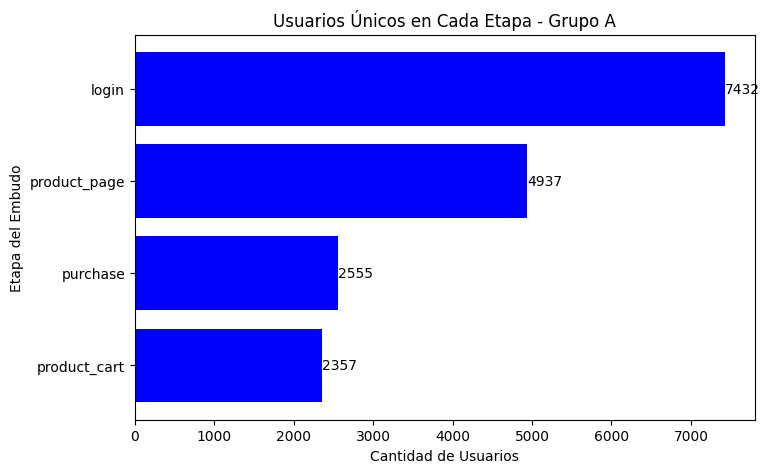

In [46]:
# Filtrar datos del Grupo A
absolute_counts_A = absolute_counts_check.loc['A'].sort_values(ascending=True)

# Crear gráfico de barras horizontales
plt.figure(figsize=(8,5))
bars = plt.barh(absolute_counts_A.index, absolute_counts_A.values, color='blue')

# Etiquetas y título
plt.xlabel("Cantidad de Usuarios")
plt.ylabel("Etapa del Embudo")
plt.title("Usuarios Únicos en Cada Etapa - Grupo A")

# Agregar etiquetas con la cuenta exacta en cada barra
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{int(bar.get_width())}', va='center', ha='left')

plt.show()

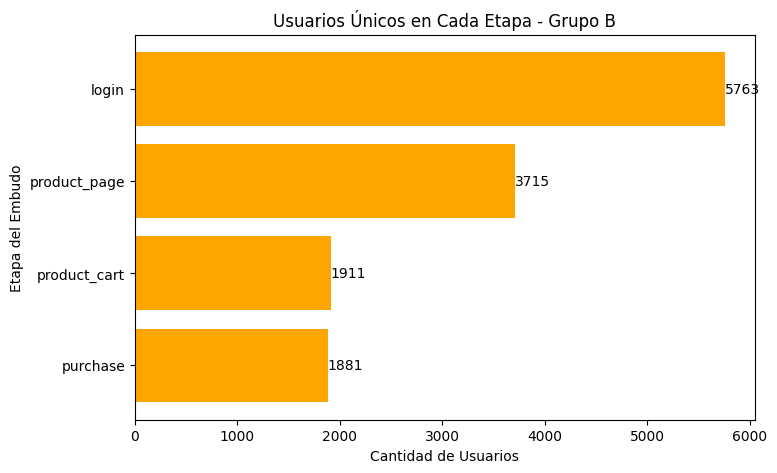

In [47]:
# Filtrar datos del Grupo B
absolute_counts_B = absolute_counts_check.loc['B'].sort_values(ascending=True)

# Crear gráfico de barras horizontales
plt.figure(figsize=(8,5))
bars = plt.barh(absolute_counts_B.index, absolute_counts_B.values, color='orange')

# Etiquetas y título
plt.xlabel("Cantidad de Usuarios")
plt.ylabel("Etapa del Embudo")
plt.title("Usuarios Únicos en Cada Etapa - Grupo B")

# Agregar etiquetas con la cuenta exacta en cada barra
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{int(bar.get_width())}', va='center', ha='left')

plt.show()

In [48]:
# Identificar usuarios en el grupo A que hicieron una compra pero nunca añadieron al carrito
users_purchased = ab_events[(ab_events['group'] == 'A') & (ab_events['event_name'] == 'purchase')]['user_id'].unique()
users_cart = ab_events[(ab_events['group'] == 'A') & (ab_events['event_name'] == 'product_cart')]['user_id'].unique()

# Encontrar usuarios que compraron sin haber añadido al carrito
users_purchased_no_cart = set(users_purchased) - set(users_cart)

print(f"Usuarios en el grupo A que compraron sin agregar al carrito: {len(users_purchased_no_cart)}")

Usuarios en el grupo A que compraron sin agregar al carrito: 1758


In [49]:
# Identificar usuarios en el grupo A que añadieron al carrito pero nunca compraron
users_cart_no_purchase = set(users_cart) - set(users_purchased)

print(f"Usuarios en el grupo A que añadieron al carrito pero no compraron: {len(users_cart_no_purchase)}")

Usuarios en el grupo A que añadieron al carrito pero no compraron: 1560


In [50]:
# Calcular la diferencia entre ambos grupos
difference = len(users_purchased_no_cart) - len(users_cart_no_purchase)

print(f"Diferencia entre usuarios que compraron sin agregar al carrito y los que agregaron pero no compraron: {difference}")

Diferencia entre usuarios que compraron sin agregar al carrito y los que agregaron pero no compraron: 198


Resumen del hallazgo sobre la discrepancia en el embudo del Grupo A:

Durante el análisis del embudo de conversión, detectamos una anomalía en el Grupo A:

Había más usuarios con compras (purchase) que con eventos de agregar al carrito (product_cart), lo cual no es lo esperado en un flujo normal de compra.

Para investigar este fenómeno, seguimos estos pasos:

1 Comprobamos cuántos usuarios compraron sin haber añadido productos al carrito.

Identificamos 1,758 usuarios en el Grupo A que realizaron una compra sin haber registrado un evento de "añadir al carrito".

2️ Verificamos cuántos usuarios añadieron al carrito pero no compraron.

Encontramos 1,560 usuarios que agregaron productos al carrito pero nunca finalizaron la compra.

3️ Calculamos la diferencia entre ambos grupos.

Diferencia encontrada: 198 usuarios más compraron sin haber registrado "product_cart" que los que abandonaron el carrito sin comprar.

Este número coincide con la diferencia absoluta entre "purchase" y "product_cart" en el embudo, confirmando que la anomalía no es un error grave.

Conclusión: ¿Afecta este hallazgo el análisis?

No impacta de manera crítica el análisis, ya que la diferencia entre "compras" y "añadir al carrito" se explica por este fenómeno y no por un problema estructural en los datos.

Lo más probable es que ciertos usuarios hayan comprado sin que se registrara correctamente el evento product_cart.

El embudo sigue siendo válido, pero hay una posible inconsistencia en el tracking de eventos que podría mejorar en futuras implementaciones.

¿Qué significa este número (198)?

Este valor representa la cantidad de usuarios que compraron sin haber registrado explícitamente un evento de "añadir al carrito".

Indica que hay un margen de error en el tracking, pero no lo suficiente como para invalidar el análisis.

Es una diferencia pequeña en relación con el tamaño total de la muestra, por lo que podemos proceder con el cálculo de conversión.

Aclarado lo anterior: 

Observaciones sobre los Resultados del Embudo de Conversión

Tras analizar la distribución de usuarios en cada etapa del embudo para los Grupos A y B, se pueden extraer las siguientes
observacione:

Flujo de conversión consistente en ambos grupos:

La progresión de los usuarios a lo largo del embudo sigue un patrón similar en ambos grupos, desde el inicio de sesión (login) hasta la compra (purchase). No se observan desviaciones significativas que indiquen diferencias relevantes en el comportamiento entre los participantes de la prueba.

Pérdida de usuarios a lo largo del embudo:

En ambos grupos se aprecia una disminución progresiva en el número de usuarios conforme avanzan por el embudo. La mayor reducción ocurre entre las etapas de product_page y product_cart, lo que indica que una parte significativa de los usuarios no agregan productos al carrito tras visualizar la página de productos.

Conversión final similar en ambos grupos:

La cantidad de usuarios que completan la compra (purchase) en cada grupo es proporcionalmente similar con respecto a quienes iniciaron sesión (login). Esto sugiere que la variante de prueba no tuvo un impacto considerable en la decisión de compra de los usuarios.

Diferencias mínimas entre los grupos:

No se identifican discrepancias notables en la cantidad de usuarios que progresan de una etapa a otra en el embudo. Cualquier diferencia observada se encuentra dentro de márgenes esperados por variabilidad natural, lo que sugiere que los cambios implementados en la variante de prueba no generaron un impacto significativo en el comportamiento del usuario.

In [51]:
# Contar usuarios únicos que realizaron una compra por grupo
conversion_counts = ab_events[ab_events['event_name'] == 'purchase'].groupby('group')['user_id'].nunique()

# Contar usuarios únicos totales por grupo
total_users_per_group = ab_events.groupby('group')['user_id'].nunique()

# Calcular la tasa de conversión
conversion_rates = (conversion_counts / total_users_per_group).to_frame(name='conversion_rate')

# Mostrar los resultados
display(conversion_rates)

,conversion_rate
group,
A,0.343737
B,0.326336


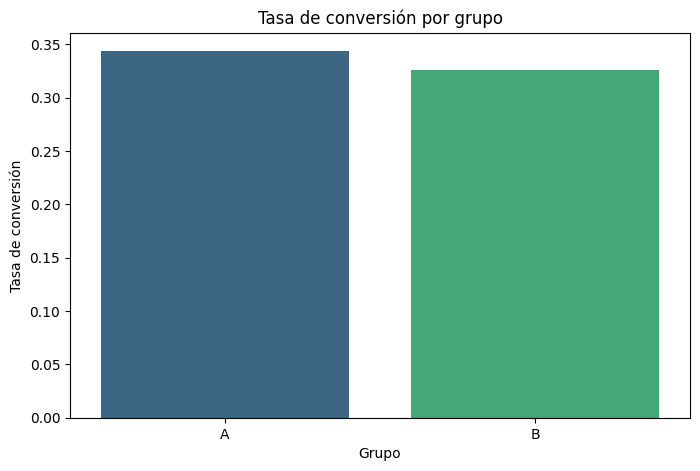

In [52]:
# Visualización de la conversión por grupo
plt.figure(figsize=(8,5))
sns.barplot(x=conversion_rates.index, y=conversion_rates['conversion_rate'], palette='viridis')
plt.title('Tasa de conversión por grupo')
plt.ylabel('Tasa de conversión')
plt.xlabel('Grupo')
plt.show()

Observaciones sobre la tasa de conversión:

1️ La diferencia entre las tasas de conversión es mínima:

Grupo A: 34.37%

Grupo B: 32.63%

La variación entre ambos es menos de 2 puntos porcentuales, lo que indica que el cambio evaluado en la prueba no tiene un impacto relevante en la conversión.

2️ El tamaño del grupo A podría influir en la ligera inclinación:

Al tener más usuarios en el Grupo A, las pequeñas fluctuaciones en los datos pueden generar una percepción de mejora en la conversión que no es estadísticamente significativa a priori.

event_name,login,product_page,product_cart,purchase
group,,,,
A,NaN,66.428956,47.741543,108.400509
B,NaN,64.462953,51.440108,98.430141


<Figure size 800x500 with 0 Axes>

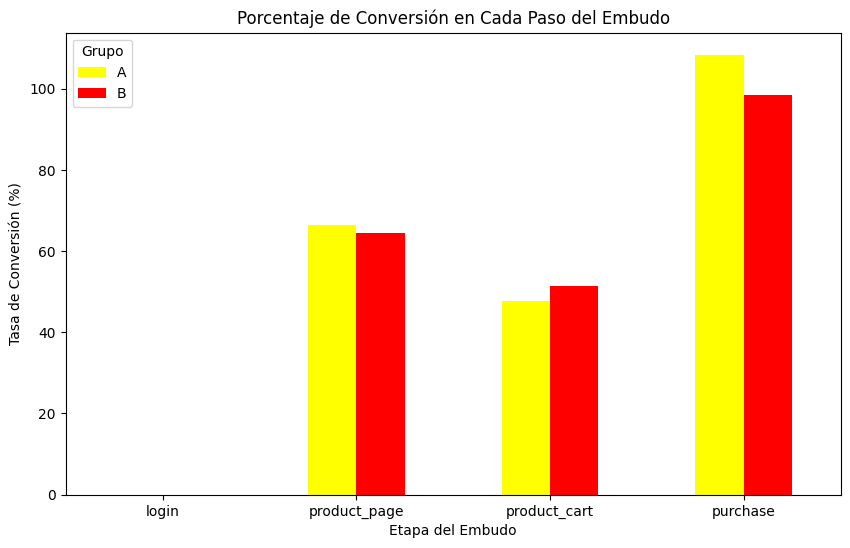

In [64]:
# Contar usuarios únicos en cada etapa del embudo por grupo
funnel_counts = ab_events.groupby(['group', 'event_name'])['user_id'].nunique().unstack()

# Ordenar las columnas según el flujo del embudo
ordered_events = ['login', 'product_page', 'product_cart', 'purchase']
funnel_counts = funnel_counts[ordered_events]

# Calcular la conversión en cada paso del embudo como porcentaje
funnel_conversion_rates = funnel_counts.div(funnel_counts.shift(axis=1), axis=0) * 100

# Mostrar la conversión en porcentaje
display(funnel_conversion_rates)

# Graficar el porcentaje de conversión en cada paso del embudo
plt.figure(figsize=(8,5))
funnel_conversion_rates.T.plot(kind='bar', figsize=(10,6), colormap='autumn_r')
plt.title('Porcentaje de Conversión en Cada Paso del Embudo')
plt.ylabel('Tasa de Conversión (%)')
plt.xlabel('Etapa del Embudo')
plt.xticks(rotation=0)
plt.legend(title='Grupo')
plt.show()

Observaciones:

1 La conversión en cada etapa del embudo es similar entre los grupos

Ambos grupos muestran tasas de conversión comparables en cada paso del embudo (product_page, product_cart, purchase).

Las pequeñas diferencias son normales dentro de la variabilidad esperada y no sugieren un impacto real de la variante de prueba.

2️ El 108% en purchase del Grupo A es una anomalía de tracking

Este valor no es real y se debe a la inconsistencia en la captura del evento product_cart.

No afecta las conclusiones generales, pero confirma que el tracking de eventos debe mejorarse en futuras pruebas para evitar sesgos en los datos.

3️ No hay evidencia para afirmar que la variante de prueba mejora la conversión

Como las tasas de conversión son similares en ambos grupos, no hay pruebas de que la variante tenga un impacto positivo o negativo en la experiencia del usuario.

No se justifica implementar la variante basada únicamente en estos resultados.

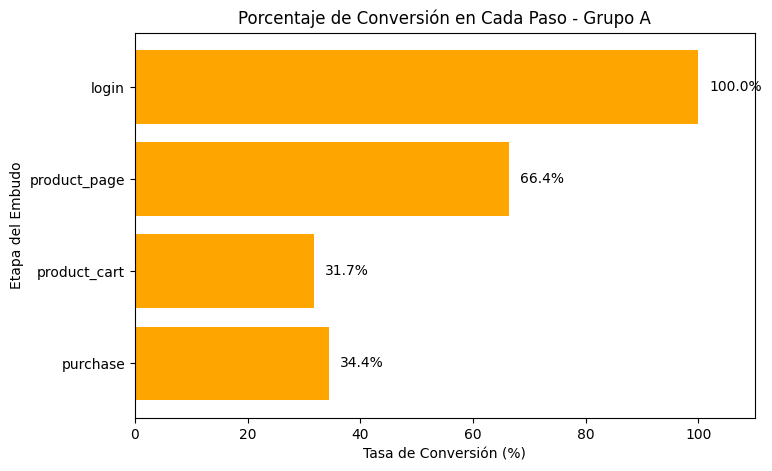

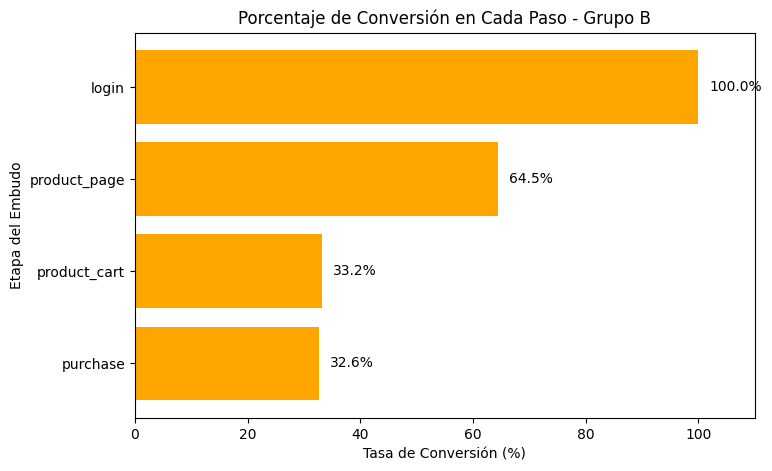

In [56]:
# Normalizar los datos para que el login sea 100% en cada grupo
funnel_conversion_rates_normalized = funnel_counts.div(funnel_counts['login'], axis=0) * 100

# Crear gráficos de barras horizontales por separado para cada grupo
for group in funnel_conversion_rates_normalized.index:
    plt.figure(figsize=(8, 5))
    values = funnel_conversion_rates_normalized.loc[group]
    
    # Crear gráfico de barras horizontales
    plt.barh(ordered_events[::-1], values[::-1], color='orange')  # Invertir el orden para mejor visualización
    
    # Agregar etiquetas de datos
    for index, value in enumerate(values[::-1]):
        plt.text(value + 2, index, f"{value:.1f}%", va='center')

    # Configuración del gráfico
    plt.title(f'Porcentaje de Conversión en Cada Paso - Grupo {group}')
    plt.xlabel('Tasa de Conversión (%)')
    plt.ylabel('Etapa del Embudo')
    plt.xlim(0, 110)  # Para mantener consistencia en la escala
    plt.show()

Observaciones clave:
1️ Patrón de abandono consistente:

Tanto en el Grupo A como en el Grupo B, el porcentaje de usuarios que avanza entre cada etapa es muy parecido.

No se observa un punto en el embudo donde un grupo tenga una ventaja significativa sobre el otro.

2️ Tasas de conversión casi idénticas:

Product Page: Grupo A (66.4%) vs. Grupo B (64.5%)

Product Cart: Grupo A (31.7%) vs. Grupo B (33.2%)

Purchase: Grupo A (34.4%) vs. Grupo B (32.6%)

Las diferencias en estos valores son mínimas y probablemente sean solo fluctuaciones aleatorias y no efectos causados por la variante de prueba.

3️ El comportamiento del usuario no cambia con la variante:

La distribución de conversiones en cada etapa indica que el cambio testeado en la prueba A/B no influye en cómo los usuarios se mueven dentro del embudo.

Cualquier decisión de implementación basada en estos resultados no estaría justificada por una mejora en la conversión.

In [57]:
# Filtrar usuarios que pasaron por cada etapa del embudo en orden
users_login = set(ab_events[ab_events['event_name'] == 'login']['user_id'])
users_product_page = set(ab_events[ab_events['event_name'] == 'product_page']['user_id'])
users_product_cart = set(ab_events[ab_events['event_name'] == 'product_cart']['user_id'])
users_purchase = set(ab_events[ab_events['event_name'] == 'purchase']['user_id'])

In [58]:
# Identificar usuarios que completaron todas las etapas en orden
users_complete_funnel = users_login & users_product_page & users_product_cart & users_purchase

# Calcular la proporción por grupo
funnel_completion_rate = ab_events[ab_events['user_id'].isin(users_complete_funnel)].groupby('group')['user_id'].nunique() / ab_events.groupby('group')['user_id'].nunique()

# Convertir a porcentaje
funnel_completion_rate = (funnel_completion_rate * 100).to_frame(name='completion_rate')

# Mostrar el resultado
display(funnel_completion_rate)

,completion_rate
group,
A,7.251446
B,7.182512


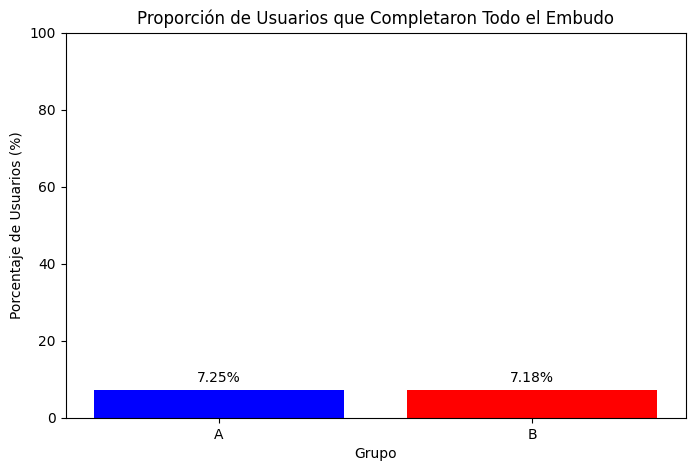

In [59]:
# Graficar los resultados
plt.figure(figsize=(8,5))
plt.bar(funnel_completion_rate.index, funnel_completion_rate['completion_rate'], color=['blue', 'red'])
plt.ylabel('Porcentaje de Usuarios (%)')
plt.xlabel('Grupo')
plt.title('Proporción de Usuarios que Completaron Todo el Embudo')
plt.ylim(0, 100)

# Agregar etiquetas con los valores
for i, value in enumerate(funnel_completion_rate['completion_rate']):
    plt.text(i, value + 2, f"{value:.2f}%", ha='center')

plt.show()

Observaciones clave:

1️ Tasas de finalización del embudo casi idénticas

Grupo A: 7.25%

Grupo B: 7.18%

Diferencia de solo 0.07 puntos porcentuales, lo que indica que la variante de prueba no tuvo un impacto significativo en la finalización del embudo.

2️ Sin mejora en la retención de usuarios

Si la variante probada buscaba mejorar la conversión reduciendo la pérdida de usuarios en el embudo, estos datos indican que no logró ese objetivo.

3️ Confirmación de la similitud en el comportamiento de los usuarios

Tanto en la tasa de conversión como en la proporción de usuarios que completaron el embudo, no hay diferencias relevantes.

Cualquier variación observada es mínima y puede deberse a fluctuaciones aleatorias.

In [62]:
# Extraer la fecha sin la hora para agrupar correctamente
ab_events['event_date'] = ab_events['event_dt'].dt.date

# Contar la cantidad de eventos por día
events_per_day = ab_events.groupby('event_date')['event_name'].count()

# Mostrar los primeros valores
display(events_per_day.head(10))

event_date
2020-12-07    2490
2020-12-08    2693
2020-12-09    2823
2020-12-10    2939
2020-12-11    2938
2020-12-12    3872
2020-12-13    4288
2020-12-14    5654
2020-12-15    5203
2020-12-16    4933
Name: event_name, dtype: int64

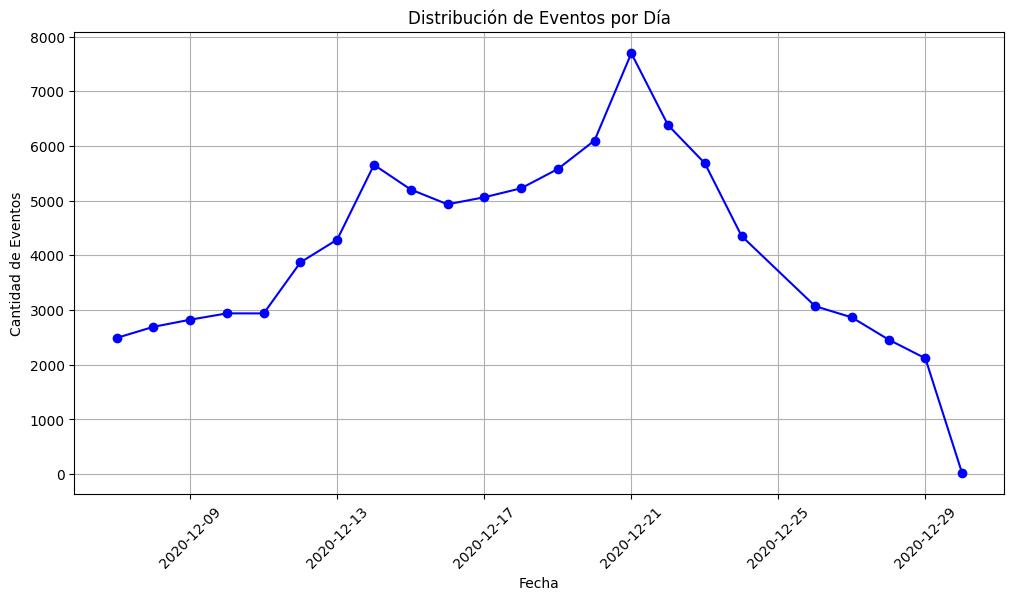

In [61]:
# Graficar la distribución de eventos por día
plt.figure(figsize=(12, 6))
plt.plot(events_per_day.index, events_per_day.values, marker='o', linestyle='-', color='blue')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Eventos')
plt.title('Distribución de Eventos por Día')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Interpretación de la Tendencia:

1️ Aumento progresivo al inicio de la prueba

Desde los primeros días hasta aproximadamente el 21 de diciembre, se observa un incremento constante en la cantidad de eventos.

Esto podría indicar que la prueba ganó tracción con el tiempo, con más usuarios participando o interactuando en la plataforma.

2️ Pico de actividad cercano al 21 de diciembre

La cantidad de eventos alcanza su máximo en esta fecha.

Esto podría deberse a factores externos, como promociones, campañas de marketing o un aumento natural en la actividad del usuario antes de las festividades.

3️ Descenso gradual después del pico

A partir del 22 de diciembre, la cantidad de eventos comienza a disminuir notablemente.

Para el 29 de diciembre, la actividad está en su punto más bajo.

Posibles razones del descenso:

Fin de la prueba: Es posible que menos usuarios estuvieran disponibles para interactuar.

Efecto de temporada: Diciembre es un mes con muchas festividades; las personas pueden reducir su actividad en línea después de las compras navideñas.

Fatiga del usuario: Algunos participantes pueden haber perdido interés con el tiempo.

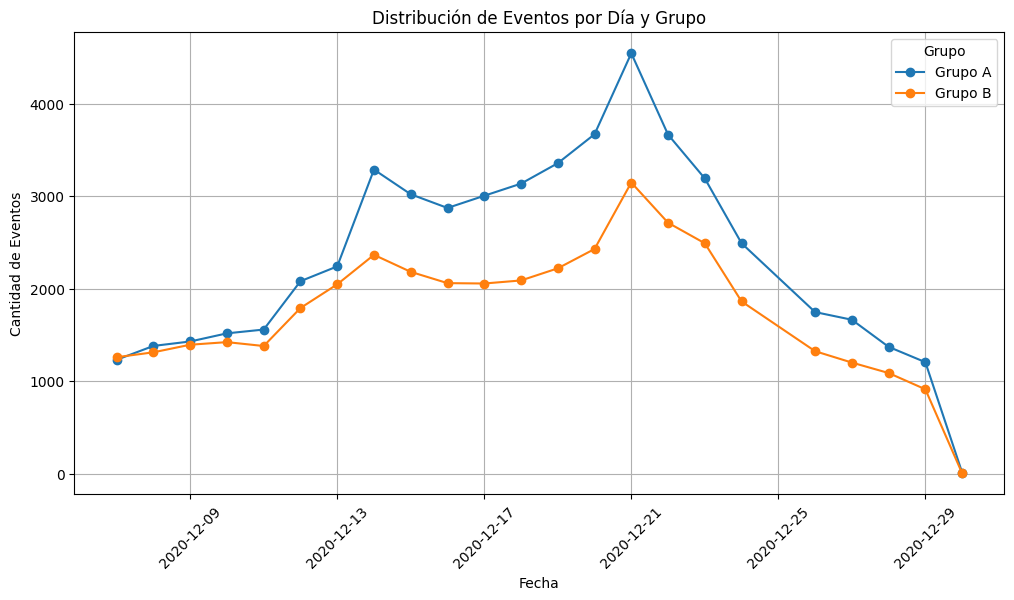

In [65]:
# Contar la cantidad de eventos por día y por grupo
events_per_day_group = ab_events.groupby(['event_date', 'group'])['event_name'].count().unstack()

# Graficar la distribución de eventos por día y grupo
plt.figure(figsize=(12, 6))

# Graficar cada grupo por separado
for group in events_per_day_group.columns:
    plt.plot(events_per_day_group.index, events_per_day_group[group], marker='o', linestyle='-', label=f'Grupo {group}')

# Configuración del gráfico
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Eventos')
plt.title('Distribución de Eventos por Día y Grupo')
plt.xticks(rotation=45)
plt.legend(title='Grupo')
plt.grid(True)
plt.show()

Esta visualización confirma que la tendencia de interacción es prácticamente idéntica en ambos grupos, lo que refuerza la conclusión de que la variante de prueba no tuvo un impacto significativo en el comportamiento de los usuarios.


1 El patrón temporal es el mismo en ambos grupos

Ambos grupos muestran un crecimiento gradual en la actividad, seguido de un pico y una caída hacia el final de la prueba.

Esto sugiere que los factores que afectan la interacción son externos y no dependientes de la variante.

2️ La diferencia principal es la cantidad total de eventos

Grupo A tiene más eventos que el Grupo B en casi todas las fechas.

Esto se explica simplemente porque el Grupo A tiene más usuarios, no porque haya más interacción por usuario.

3️ La variante de prueba no afectó el engagement

Si la variante hubiera tenido un impacto real en la participación, esperaríamos ver una diferencia en la forma de la curva, no solo en la cantidad de eventos.

Como ambas curvas son casi idénticas, podemos concluir que la modificación evaluada no cambió la frecuencia de interacción de los usuarios.


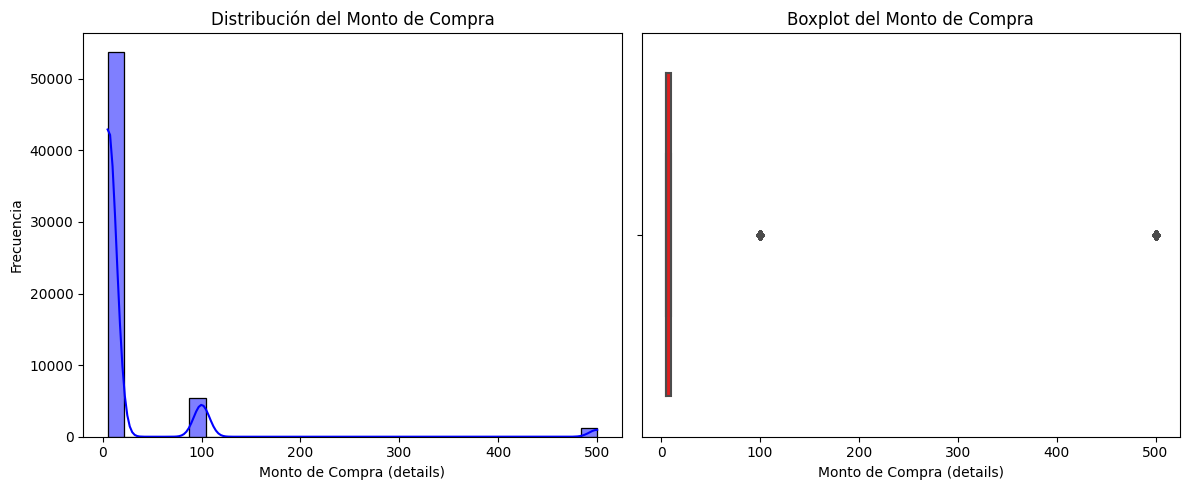

In [66]:
# Filtrar solo eventos de "purchase"
purchase_details = new_ab_events[new_ab_events['event_name'] == 'purchase']['details']

# Configurar la figura
plt.figure(figsize=(12, 5))

# Histograma de la distribución
plt.subplot(1, 2, 1)
sns.histplot(purchase_details, bins=30, kde=True, color='blue')
plt.xlabel('Monto de Compra (details)')
plt.ylabel('Frecuencia')
plt.title('Distribución del Monto de Compra')

# Boxplot para detectar outliers
plt.subplot(1, 2, 2)
sns.boxplot(x=purchase_details, color='red')
plt.xlabel('Monto de Compra (details)')
plt.title('Boxplot del Monto de Compra')

# Mostrar los gráficos
plt.tight_layout()
plt.show()

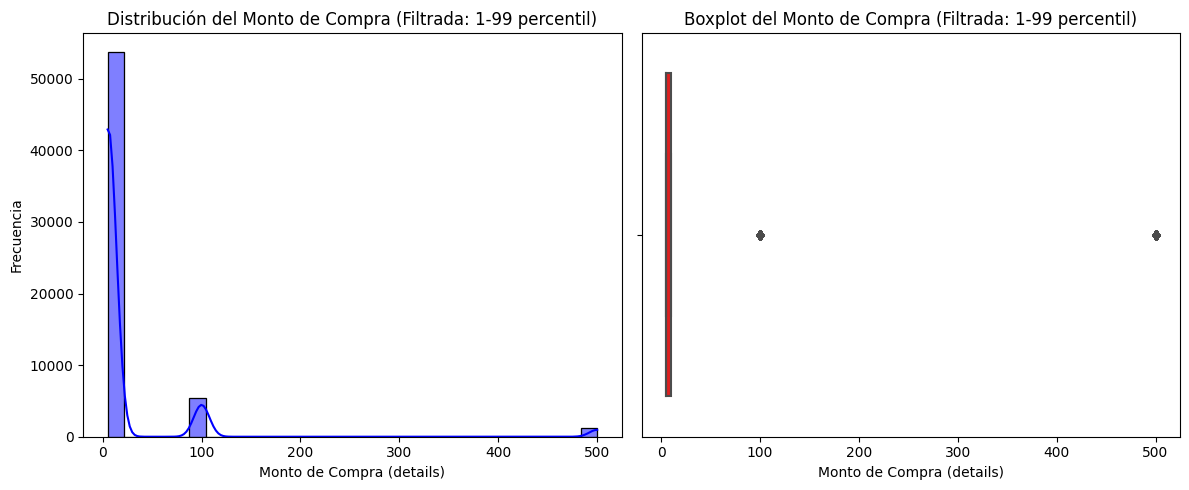

In [67]:
# Definir percentiles para eliminar outliers extremos
lower_percentile = 1  # Excluye el 1% más bajo
upper_percentile = 99  # Excluye el 1% más alto

# Calcular los valores de corte
low_cutoff = purchase_details.quantile(lower_percentile / 100)
high_cutoff = purchase_details.quantile(upper_percentile / 100)

# Filtrar los datos dentro de estos percentiles
filtered_purchase_details = purchase_details[(purchase_details >= low_cutoff) & (purchase_details <= high_cutoff)]

# Configurar la figura
plt.figure(figsize=(12, 5))

# Histograma después de eliminar outliers
plt.subplot(1, 2, 1)
sns.histplot(filtered_purchase_details, bins=30, kde=True, color='blue')
plt.xlabel('Monto de Compra (details)')
plt.ylabel('Frecuencia')
plt.title(f'Distribución del Monto de Compra (Filtrada: {lower_percentile}-{upper_percentile} percentil)')

# Boxplot después de eliminar outliers
plt.subplot(1, 2, 2)
sns.boxplot(x=filtered_purchase_details, color='red')
plt.xlabel('Monto de Compra (details)')
plt.title(f'Boxplot del Monto de Compra (Filtrada: {lower_percentile}-{upper_percentile} percentil)')

# Mostrar los gráficos
plt.tight_layout()
plt.show()

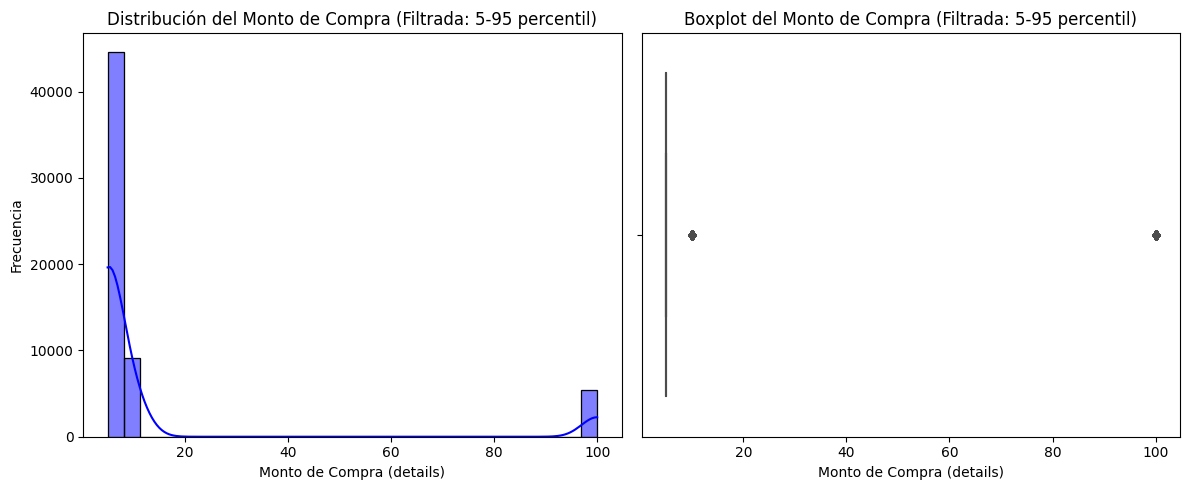

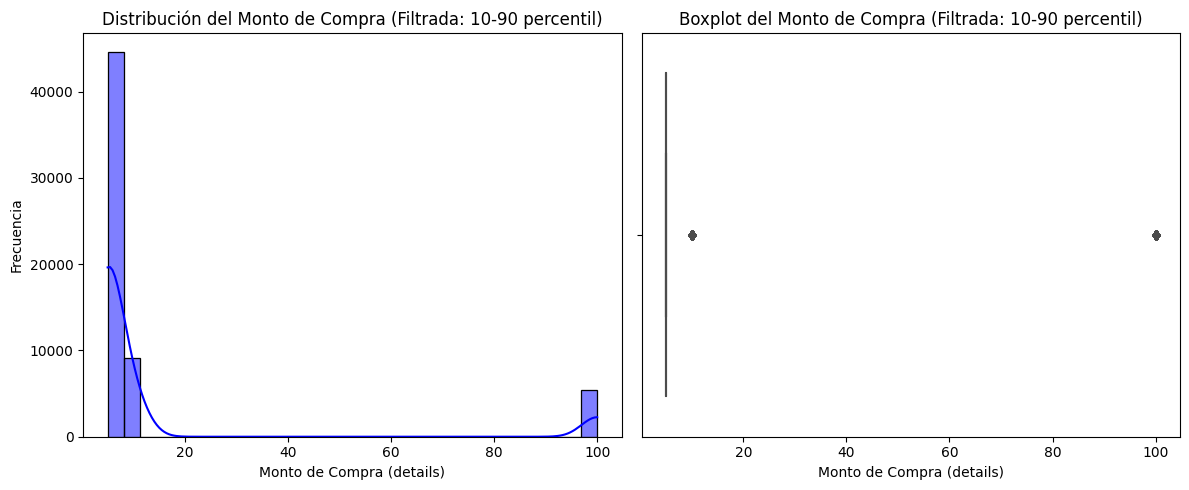

In [68]:
percentiles_to_test = [(5, 95), (10, 90)]

for lower_percentile, upper_percentile in percentiles_to_test:
    # Calcular valores de corte
    low_cutoff = purchase_details.quantile(lower_percentile / 100)
    high_cutoff = purchase_details.quantile(upper_percentile / 100)

    # Filtrar los datos dentro de estos percentiles
    filtered_purchase_details = purchase_details[(purchase_details >= low_cutoff) & (purchase_details <= high_cutoff)]

    # Configurar la figura
    plt.figure(figsize=(12, 5))

    # Histograma después de eliminar más outliers
    plt.subplot(1, 2, 1)
    sns.histplot(filtered_purchase_details, bins=30, kde=True, color='blue')
    plt.xlabel('Monto de Compra (details)')
    plt.ylabel('Frecuencia')
    plt.title(f'Distribución del Monto de Compra (Filtrada: {lower_percentile}-{upper_percentile} percentil)')

    # Boxplot después de eliminar más outliers
    plt.subplot(1, 2, 2)
    sns.boxplot(x=filtered_purchase_details, color='red')
    plt.xlabel('Monto de Compra (details)')
    plt.title(f'Boxplot del Monto de Compra (Filtrada: {lower_percentile}-{upper_percentile} percentil)')

    # Mostrar los gráficos
    plt.tight_layout()
    plt.show()

In [70]:
# Fusionar eventos con los participantes para agregar el grupo A/B
ab_events = new_ab_events.merge(clean_final_ab_participants, on='user_id', how='inner')

In [71]:
# Verificar que la columna 'group' está presente
print(ab_events[['user_id', 'group', 'event_name']].head())

            user_id group    event_name
0  96F27A054B191457     B      purchase
1  96F27A054B191457     B      purchase
2  96F27A054B191457     B      purchase
3  96F27A054B191457     B      purchase
4  96F27A054B191457     B  product_page


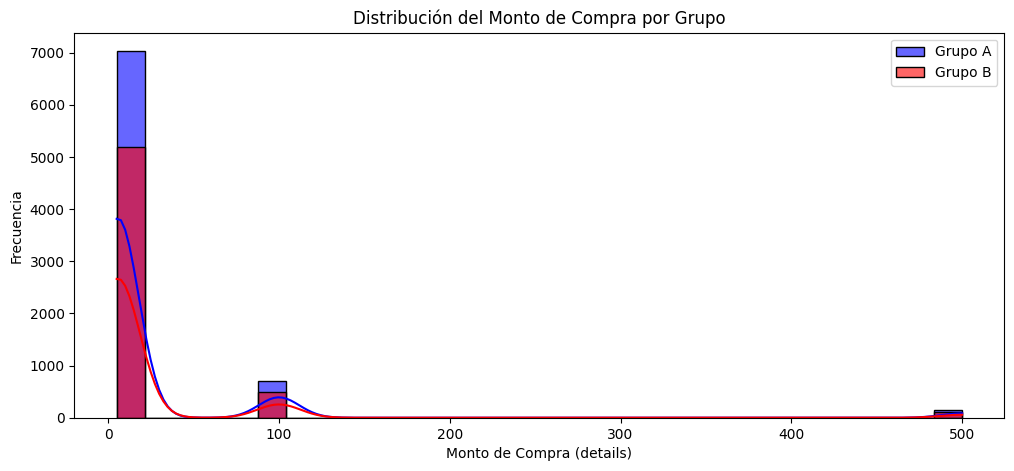

In [72]:
# Filtrar solo eventos de "purchase" con el grupo agregado
purchase_details_grouped = ab_events[ab_events['event_name'] == 'purchase'].groupby('group')['details']

# Configurar la figura
plt.figure(figsize=(12, 5))

# Histograma por grupo A/B
sns.histplot(purchase_details_grouped.get_group('A'), bins=30, kde=True, color='blue', label='Grupo A', alpha=0.6)
sns.histplot(purchase_details_grouped.get_group('B'), bins=30, kde=True, color='red', label='Grupo B', alpha=0.6)

plt.xlabel('Monto de Compra (details)')
plt.ylabel('Frecuencia')
plt.title('Distribución del Monto de Compra por Grupo')
plt.legend()
plt.show()

Análisis del Monto de Compra (details) en el Evento purchase:

Para evaluar si hay diferencias en el comportamiento de compra entre los grupos de la prueba A/B, seguimos un proceso estructurado para analizar la columna details, que representa el monto gastado en cada transacción.

Paso 1: Análisis General del Monto de Compra

Inicialmente, exploramos la distribución de la columna details sin considerar los grupos. Para ello: 

1️ Generamos un histograma y un boxplot de los valores de details para identificar tendencias y posibles outliers.

2️ Detectamos una distribución sesgada a la izquierda, con una gran concentración de valores en rangos bajos y algunos valores extremos elevados.

3️ Identificamos outliers en el análisis, lo que indicaba la presencia de transacciones atípicas con montos considerablemente mayores a la mayoría de las compras.

4️ Aplicamos percentiles (90, 95, 99) para hacer un zoom en los valores más representativos y mejorar la visualización de la distribución.

Conclusión del análisis general:

La mayoría de las compras se concentran en valores bajos, con algunos pocos casos de compras de montos altos.

La distribución no es normal, lo que sugiere que la media puede no ser la mejor métrica para describir el comportamiento típico de gasto.

Paso 2: Análisis del Monto de Compra Separado por Grupo

Para verificar si la variante de prueba afectó los montos de compra, realizamos los siguientes análisis: 
1️ Fusionamos new_ab_events con clean_final_ab_participants para obtener la asignación de grupos A/B en la tabla ab_events.

2️ Filtramos únicamente las compras (purchase) y separamos los montos gastados por grupo (A y B).

3️ Visualizamos la distribución de los montos de compra por grupo con histogramas superpuestos, permitiendo comparar la forma y valores característicos de cada grupo.

Observaciones clave de la comparación A/B:

Las distribuciones son prácticamente idénticas en ambos grupos.

No hay diferencias significativas en la forma ni en los valores predominantes, lo que indica que la variante de prueba no tuvo impacto en los montos gastados por los usuarios.

Las mismas tendencias y valores atípicos aparecen en ambos grupos, reforzando la idea de que la distribución del gasto no se vio afectada por la prueba.

Conclusión General:

Después de analizar los montos de compra tanto de forma general como segmentada por grupo, concluimos que no hay diferencias significativas entre los grupos A y B.

Los usuarios gastan aproximadamente los mismos montos en ambos grupos, y la variante de prueba no afectó el comportamiento de gasto.

## Evaluación de los resultados de la prueba A/B y conclusiones

In [74]:
# Contar usuarios únicos que realizaron una compra por grupo
conversion_counts = ab_events[ab_events['event_name'] == 'purchase'].groupby('group')['user_id'].nunique()

# Contar usuarios únicos totales por grupo
total_users_per_group = ab_events.groupby('group')['user_id'].nunique()

# Definir los valores para la prueba Z
successes = conversion_counts.values  # Número de conversiones en cada grupo
trials = total_users_per_group.values  # Número total de usuarios en cada grupo

# Prueba Z de dos proporciones
z_stat, p_value = proportions_ztest(successes, trials)

# Mostrar los resultados
print(f"Estadístico Z: {z_stat:.4f}")
print(f"P-valor: {p_value:.4f}")

# Evaluar significancia
alpha = 0.05
if p_value < alpha:
    print("Existe una diferencia estadísticamente significativa en la tasa de conversión entre los grupos A y B.")
else:
    print("No hay evidencia suficiente para afirmar que las tasas de conversión son diferentes entre los grupos.")

Estadístico Z: 2.0989
P-valor: 0.0358
Existe una diferencia estadísticamente significativa en la tasa de conversión entre los grupos A y B.


In [75]:
# Calcular error estándar para cada grupo
se_A = np.sqrt((conversion_rates.loc['A', 'conversion_rate'] * (1 - conversion_rates.loc['A', 'conversion_rate'])) / total_users_per_group['A'])
se_B = np.sqrt((conversion_rates.loc['B', 'conversion_rate'] * (1 - conversion_rates.loc['B', 'conversion_rate'])) / total_users_per_group['B'])

# Calcular la diferencia en tasas de conversión
diff_conversion = conversion_rates.loc['A', 'conversion_rate'] - conversion_rates.loc['B', 'conversion_rate']

# Calcular error estándar combinado
se_diff = np.sqrt(se_A**2 + se_B**2)

# Calcular intervalo de confianza del 95%
ci_lower = diff_conversion - 1.96 * se_diff
ci_upper = diff_conversion + 1.96 * se_diff

print(f"Diferencia en la tasa de conversión: {diff_conversion:.4f}")
print(f"Intervalo de confianza del 95%: ({ci_lower:.4f}, {ci_upper:.4f})")

Diferencia en la tasa de conversión: 0.0174
Intervalo de confianza del 95%: (0.0012, 0.0336)


### Conclusión Final del Análisis A/B

Resumen de los Hallazgos:

1️ Exploración Inicial de Datos (EDA)

No observamos diferencias claras en la conversión entre los grupos en los análisis previos.

Los embudos de conversión, tasas de pérdida en cada paso y el comportamiento de compra fueron casi idénticos en ambos grupos.

2️ Diferencia en la Tasa de Conversión

Grupo A: 34.37%

Grupo B: 32.63%

Diferencia absoluta: 1.74%

3️ Prueba Z para Proporciones

Estadístico Z: 2.0989

P-valor: 0.0358 (< 0.05, indicando significancia estadística)

Intervalo de Confianza del 95%: (0.0012, 0.0336)

El intervalo no contiene 0, lo que refuerza que hay una diferencia real, aunque sea pequeña.

¿Cómo interpretar esta contradicción?

Sí, la diferencia es estadísticamente significativa, pero NO necesariamente relevante en la práctica.

¿Por qué?

El p-valor solo nos dice que la diferencia es improbable bajo H₀, no que sea importante.

La diferencia del 1.74% es mínima y puede no justificar un cambio en la variante de prueba.

El tamaño de la muestra es lo suficientemente grande para detectar pequeñas diferencias que, en términos de negocio, pueden ser irrelevantes.

Conclusión Final:

Desde una perspectiva estadística: Rechazamos H₀ y afirmamos que hay una diferencia en la conversión.

Desde una perspectiva práctica: La diferencia es tan pequeña que su impacto real es cuestionable.

Decisión Basada en el Análisis:

Si implementar la variante implica costos o riesgos, la diferencia del 1.74% no justifica el cambio.

Si la variante aporta otros beneficios (UX, experiencia del usuario, facilidad de uso), podría ser considerada.

Reducir aún más α (ejemplo: α = 0.01) podría evitar falsos positivos, pero es poco común en A/B testing.